In [1]:
%%html
<marquee style='width: 90%; color: blue;'><b>INSTITUTO INFNET | ESCOLA SUPERIOR DA
TECNOLOGIA DA INFORMAÇÃO</b></marquee>

![logo_infnet.png](https://www.infnet.edu.br/infnet/wp-content/uploads/sites/6/2021/10/infnet_mod.svg)

<h2>Pós-graduação MIT em Inteligência Artificial, Machine Learning & Deep Learning</h2>

<h3>Projeto da disciplina de Deep Learning com TensorFlow.</h3>

Bloco: Redes neurais com TensorFlow

Docente: Diego da Silva Rodrigues

Aluno: Winicius Botelho Faquieri 

---

### Um modelo de Deep Neural Networks para classificação de estabelecimentos nos segmentos Autosserviço, Mercado Quente e Mercado Frio com diferentes funções de ativação

In [1]:
# Imports:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import inflection
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from sklearn import model_selection as ms
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from keras.utils import np_utils
from keras.models import Sequential 
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

## TABLE OF CONTENTS
* [Problem and Data](#label1)    
    
* [Feature Engineering](#label3)

* [Exploratory Data Analysis (EDA)](#label4)

* [Data Preparation](#label5)

* [Feature Selection](#label6)

* [The Model](#)

* [Results](#)

* [Conclusion](#)

* [References](#)


## PROBLEM AND DATA

### Canais de distribuição - entendendo o problema<a class="anchor" id="dataset_info"></a>

Objetivo: classificar empresas do varejo relativo ao mercado de bebidas frias em 03 segmentos ou canais de distribuição, a saber:

* Segmento I - Supermercados com 5 ou mais checkouts

* Segmento II - Supermercados com 4 ou menos checkouts (mercadinhos, mercearias, etc)

* Segmento III - Bares, restaurantes, padarias

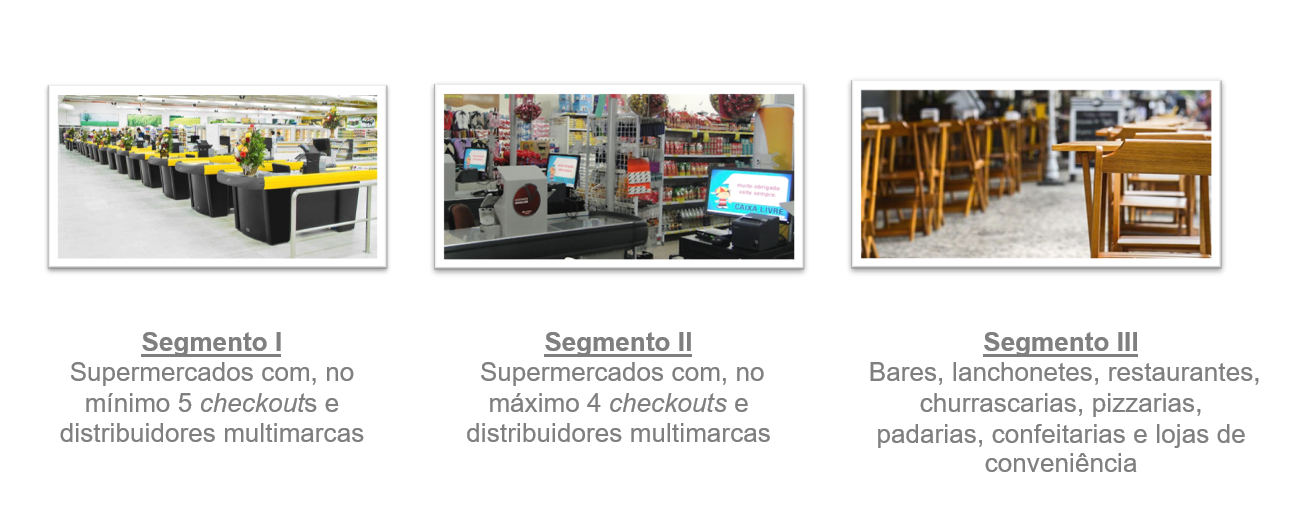

Neste notebook, um modelo de rede neural profunda é desenvolvido para classificar empresas do varejo em diferentes canais de distribuição. Existem 3 tipos de estabelecimento: varejo de autosserviço, mercado quente e mercado frio. Muitos experimentos foram feitos para o modelo com diferentes funções de ativação e para diferentes números de época. 

O objetivo final é um modelo de aprendizado de máquina que possa prever a qual segmento pertence um dado estabelecimento. Além disso, queremos avaliar vários modelos antes de escolher um como o "melhor" e depois de construir um modelo, queremos investigar as previsões. 

In [3]:
# dataset
df = pd.read_csv('../data/dataset.csv', dtype=str)

Campos/colunas:

**NUM_DOC_DEST:** identificador dos estabelecimentos

**N_TRANS:** número de transações realizadas por estabelecimento ou cupom fiscal

**VAL_UNIT_MEDIO:** valor médio de compra 

**VOLUME_COMPRA_MEDIO:** quantidade média de compras realizadas 

**CESTA_PROD_DIFER:** diversidade de produtos comprados 

Diferentes features foram utilizadas com o intuito de traçar um perfil de compra dos estabelecimentos.

In [4]:
df.head()

,NUM_DOC_DEST,N_TRANS,VAL_UNIT_MEDIO,VOLUME_COMPRA_MEDIO,CESTA_PROD_DIFER,seg
0,93209765032582,3847,21.188510626992255,3171.2399272160123,266,I
1,13004510017235,8293,20.919979153356135,295.0801881104546,244,I
2,06966628000122,1115,19.182569216795695,264.914798206278,103,I
3,30029774000106,232,14.686313469827589,62.5,56,I
4,32860231000676,2149,3.087029304447976,836.3192182410423,157,I


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   NUM_DOC_DEST         3699 non-null   object
 1   N_TRANS              3699 non-null   object
 2   VAL_UNIT_MEDIO       3699 non-null   object
 3   VOLUME_COMPRA_MEDIO  3699 non-null   object
 4   CESTA_PROD_DIFER     3699 non-null   object
 5   seg                  3699 non-null   object
dtypes: object(6)
memory usage: 173.5+ KB


### Data Dimensions <a class="anchor" id="datadim"></a>

In [4]:
print( 'Number of Rows: {}'.format( df.shape[0] ) )
print( 'Number of Cols: {}'.format( df.shape[1] ) )

Number of Rows: 3699
Number of Cols: 6


### Data Types <a class="anchor" id="datatyp"></a>

In [4]:
# Change data types
df['N_TRANS'] = df['N_TRANS'].astype( int )

# VAL_UN_COMPRA: VALOR UNITÁRIO PAGO PELA COMPRA
df['VAL_UNIT_MEDIO'] = df['VAL_UNIT_MEDIO'].astype( float )
df['VAL_UNIT_MEDIO'] = df['VAL_UNIT_MEDIO'].round(decimals = 2)

# VAL_BRUTO: VAL_UN_COMPRA X NUM_QTD_COMPRA
df['VOLUME_COMPRA_MEDIO'] = df['VOLUME_COMPRA_MEDIO'].astype( float )
df['VOLUME_COMPRA_MEDIO'] = df['VOLUME_COMPRA_MEDIO'].round(decimals = 2)

df['CESTA_PROD_DIFER'] = df['CESTA_PROD_DIFER'].astype( int )

df.dtypes

NUM_DOC_DEST            object
N_TRANS                  int32
VAL_UNIT_MEDIO         float64
VOLUME_COMPRA_MEDIO    float64
CESTA_PROD_DIFER         int32
seg                     object
dtype: object

### Check NA<a class="anchor" id="checkna"></a>

In [7]:
df.isna().sum()

NUM_DOC_DEST           0
N_TRANS                0
VAL_UNIT_MEDIO         0
VOLUME_COMPRA_MEDIO    0
CESTA_PROD_DIFER       0
seg                    0
dtype: int64

### Descriptive statistics <a class="anchor" id="descrstats"></a>

In [9]:
num_attributes = df.select_dtypes( include=['int32', 'float64'] )
cat_attributes = df.select_dtypes( exclude=['int32', 'float64','datetime64[ns]'] )

- Numerical atributes <a class="anchor" id="numstats"></a>

In [8]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,N_TRANS,1.00,8752.00,8751.00,390.512301,151.00,717.239176,4.746505,32.516963
1,VAL_UNIT_MEDIO,0.57,104.89,104.32,17.032476,12.81,15.389505,1.648951,3.817230
2,VOLUME_COMPRA_MEDIO,10.00,9604.96,9594.96,224.864388,112.33,496.712648,7.970708,90.182047
3,CESTA_PROD_DIFER,1.00,332.00,331.00,40.104893,24.00,46.810880,2.326335,6.224756


## FEATURE ENGINEERING <a class="anchor" id="hipotes"></a>

**Hipóteses**:

- H1: VALOR UNITÁRIO MÉDIO DE COMPRA: É esperado um valor médio de compra maior em empresas do segmento 3 do que nos segmentos 1 e 2? 


- H2. QUANTIDADE COMPRADA: É esperado um volume médio de compras maior por empresas do do varejo de autosserviço do que de outros segmentos?


- H3. CESTA DE PRODUTOS DIFERENTES: é esperado um mix de produtos maior no segmento 1 do que nos segmentos 2 e 3? 


- H4. TRANSAÇÕES EFETUADAS: É esperado um número de transações realizadas ao longo do ano maior no segmento 1 do que em outros segmentos?

...


## EXPLORATY DATA ANALYSIS (EDA) <a class="anchor" id="prep"></a>

Objetivos:

- Validar hipóteses (insights)

- Perceber variáveis que são importantes para o modelo

### Distribuição da variável target

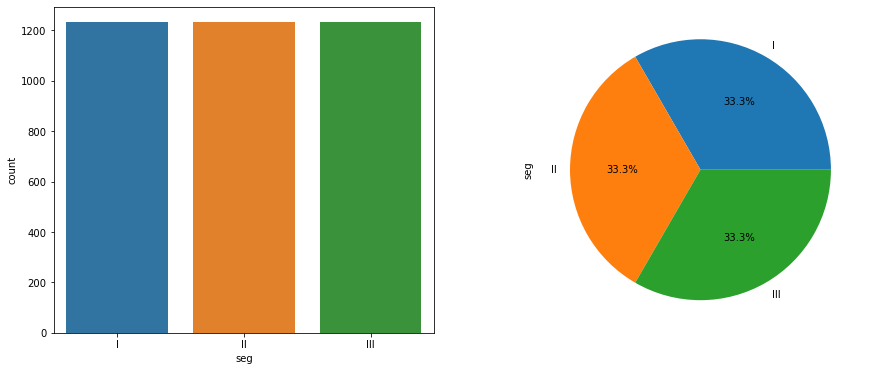

In [5]:
features = df.copy()
fig, ax=plt.subplots(1,2,figsize=(15,6))
_ = sns.countplot(x='seg', data=features, ax=ax[0])
_ = features['seg'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1])

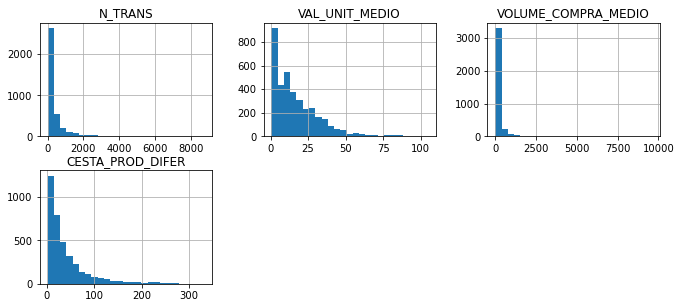

In [14]:
plt.rcParams["figure.figsize"] = (800/72., 4.8)
num_attributes.hist( bins=25, layout=(2,3) );

 - Análise bivariada:
 

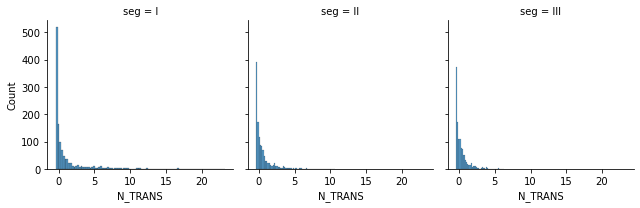

In [35]:
g = sns.FacetGrid(features2, col="seg")
g.map(sns.histplot, "N_TRANS")

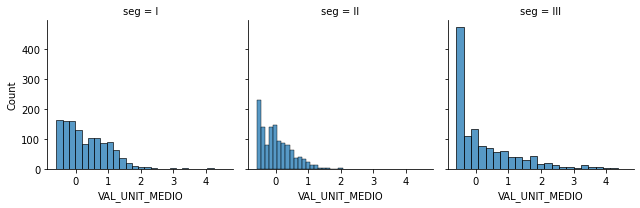

In [39]:
g = sns.FacetGrid(features2, col="seg")
g.map(sns.histplot, "VAL_UNIT_MEDIO")

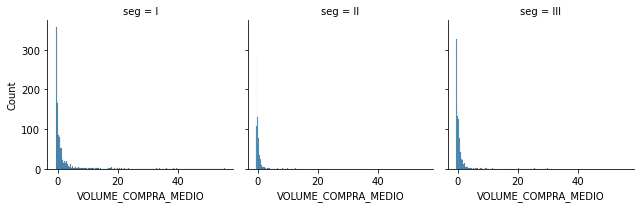

In [37]:
g = sns.FacetGrid(features2, col="seg")
g.map(sns.histplot, "VOLUME_COMPRA_MEDIO")

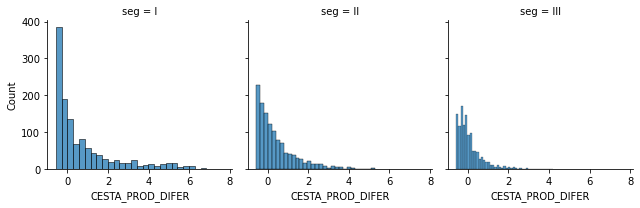

In [38]:
g = sns.FacetGrid(features2, col="seg")
g.map(sns.histplot, "CESTA_PROD_DIFER")

<AxesSubplot:xlabel='N_TRANS', ylabel='Density'>

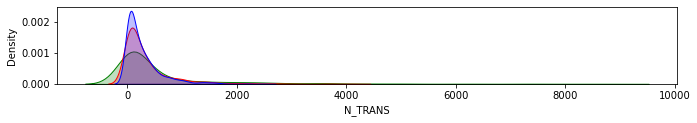

In [6]:
plt.rcParams["figure.figsize"] = (800/72., 4.8)
plt.subplot( 3, 1, 1 )
sns.kdeplot( features[features['seg'] == 'I']['N_TRANS'], label='SEGMENTO I', shade=True, color = 'green')
sns.kdeplot( features[features['seg'] == 'II']['N_TRANS'], label='SEGMENTO II', shade=True, color = 'red' )
sns.kdeplot( features[features['seg'] == 'III']['N_TRANS'], label='SEGMENTO III', shade=True, color = 'blue' )

<AxesSubplot:xlabel='VAL_UNIT_MEDIO', ylabel='Density'>

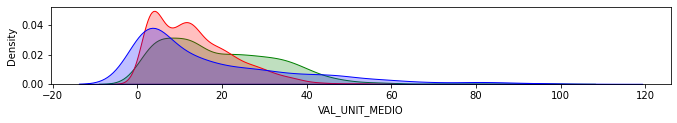

In [7]:
plt.subplot( 3, 1, 1 )
sns.kdeplot( features[features['seg'] == 'I']['VAL_UNIT_MEDIO'], label='SEGMENTO I', shade=True, color = 'green')
sns.kdeplot( features[features['seg'] == 'II']['VAL_UNIT_MEDIO'], label='SEGMENTO II', shade=True, color = 'red' )
sns.kdeplot( features[features['seg'] == 'III']['VAL_UNIT_MEDIO'], label='SEGMENTO III', shade=True, color = 'blue' )

<AxesSubplot:xlabel='VOLUME_COMPRA_MEDIO', ylabel='Density'>

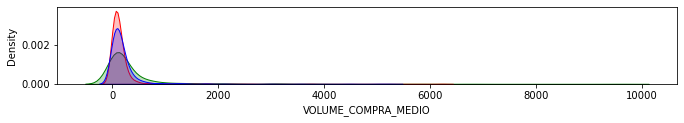

In [8]:
plt.subplot( 3, 1, 1 )
sns.kdeplot( features[features['seg'] == 'I']['VOLUME_COMPRA_MEDIO'], label='SEGMENTO I', shade=True, color = 'green' )
sns.kdeplot( features[features['seg'] == 'II']['VOLUME_COMPRA_MEDIO'], label='SEGMENTO II', shade=True , color = 'red')
sns.kdeplot( features[features['seg'] == 'III']['VOLUME_COMPRA_MEDIO'], label='SEGMENTO III', shade=True , color = 'blue')

<AxesSubplot:xlabel='CESTA_PROD_DIFER', ylabel='Density'>

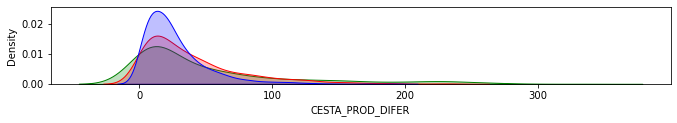

In [11]:
plt.subplot( 3, 1, 1 )
sns.kdeplot( features[features['seg'] == 'I']['CESTA_PROD_DIFER'], label='SEGMENTO I', shade=True, color = 'green')
sns.kdeplot( features[features['seg'] == 'II']['CESTA_PROD_DIFER'], label='SEGMENTO II', shade=True, color = 'red' )
sns.kdeplot( features[features['seg'] == 'III']['CESTA_PROD_DIFER'], label='SEGMENTO III', shade=True, color = 'blue' )

Vamos dar uma olhada nas correlações entre todas as variáveis domésticas. Se houver alguma que seja muito correlacionada, talvez queiramos remover um dos pares de variáveis altamente correlacionadas.

O código a seguir identifica quaisquer variáveis com uma correlação de magnitude absoluta maior que 0,95.

In [13]:
# Create correlation matrix
corr_matrix = features.corr()


# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

C:\Users\Winicius\AppData\Local\Temp\ipykernel_608\3712635670.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


[]

In [17]:
corr_matrix

,N_TRANS,VAL_UNIT_MEDIO,VOLUME_COMPRA_MEDIO,CESTA_PROD_DIFER
N_TRANS,1.000000,-0.096738,0.182676,0.865918
VAL_UNIT_MEDIO,-0.096738,1.000000,-0.141891,-0.084796
VOLUME_COMPRA_MEDIO,0.182676,-0.141891,1.000000,0.170664
CESTA_PROD_DIFER,0.865918,-0.084796,0.170664,1.000000


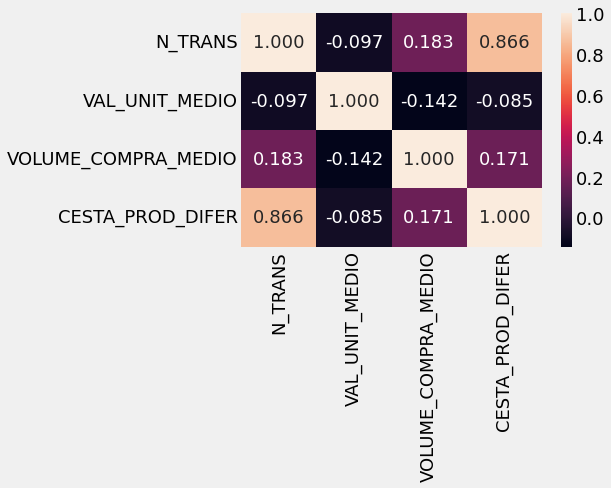

In [24]:
sns.heatmap(corr_matrix, annot=True, fmt='.3f');

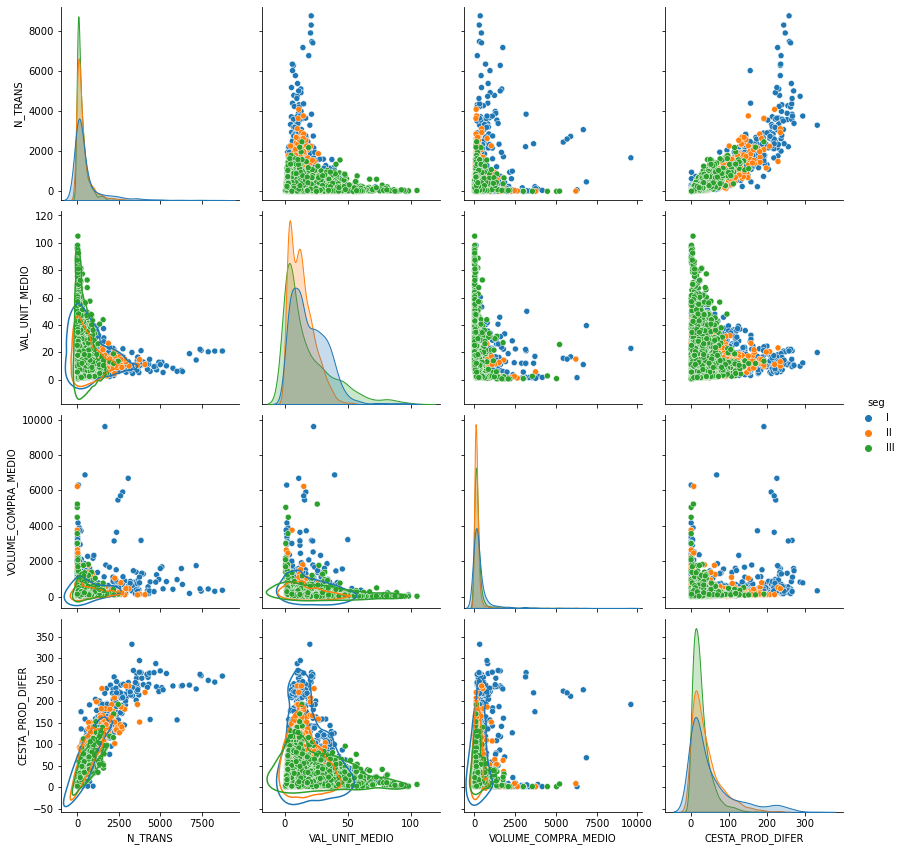

In [20]:
# SCATTER PLOT
g = sns.pairplot(features, hue='seg', height=3, diag_kind='kde')
_ = g.map_lower(sns.kdeplot, levels=1, color=".2")

### DATA PREPARATION <a class="anchor" id="prep"></a>

> O aprendizado da maioria dos algoritmos de ML é facilitado por dados numéricos, na mesma escala.

- Normalização: reescala o centro para zero com desvio-padrao igual a 1.


- Rescaling: reescala para o intervalo 0 e 1 (distribuições não Gaussianas):


    - Min-Max Scaler: utiliza o range
    - Robust Scaler: utiliza o IQR


- Transformação: conversão da feature categórica para numérica - encoding - e de natureza.

In [21]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
N_TRANS,3699.0,390.512301,717.336147,1.00,42.000,151.00,412.000,8752.00
VAL_UNIT_MEDIO,3699.0,17.032476,15.391585,0.57,4.885,12.81,24.955,104.89
VOLUME_COMPRA_MEDIO,3699.0,224.864388,496.779803,10.00,40.000,112.33,210.635,9604.96
CESTA_PROD_DIFER,3699.0,40.104893,46.817209,1.00,11.000,24.00,51.000,332.00


<AxesSubplot:xlabel='seg', ylabel='N_TRANS'>

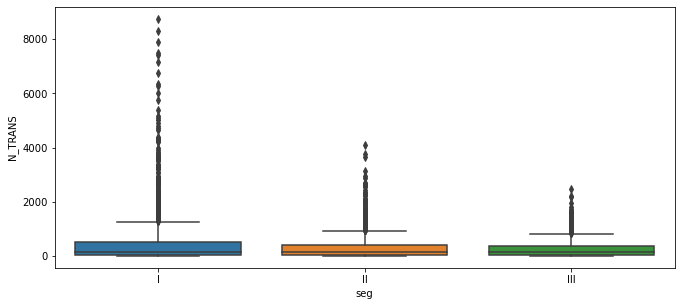

In [13]:
sns.boxplot( x='seg', y='N_TRANS', data=features )

<AxesSubplot:xlabel='seg', ylabel='VAL_UNIT_MEDIO'>

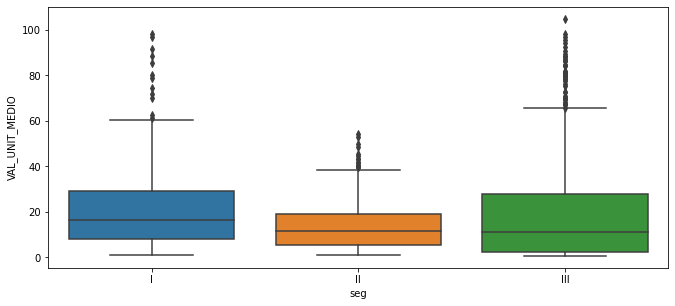

In [28]:
sns.boxplot( x='seg', y='VAL_UNIT_MEDIO', data=features )

<AxesSubplot:xlabel='seg', ylabel='VOLUME_COMPRA_MEDIO'>

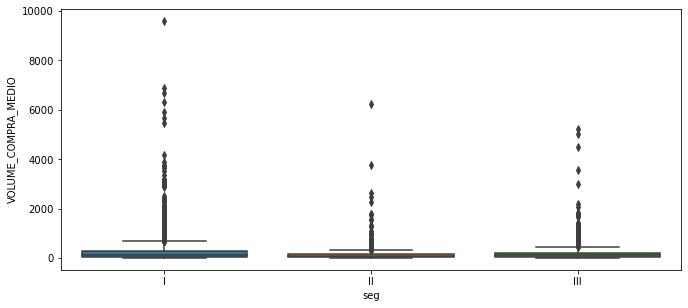

In [29]:
sns.boxplot( x='seg', y='VOLUME_COMPRA_MEDIO', data=features )

<AxesSubplot:xlabel='seg', ylabel='CESTA_PROD_DIFER'>

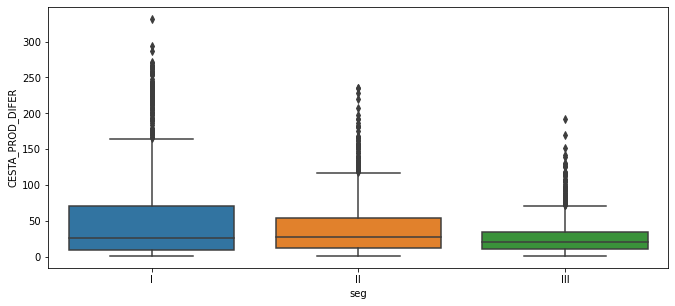

In [22]:
sns.boxplot( x='seg', y='CESTA_PROD_DIFER', data=features )

### Rescaling: Robust Scaler (RS)

Vamos utilizar o método RS devido a presença de valores atípicos. 

In [23]:
features2 = features.copy()
rs = RobustScaler()

features2['N_TRANS'] = rs.fit_transform( features2[['N_TRANS']].values )
features2['VAL_UNIT_MEDIO'] = rs.fit_transform( features2[['VAL_UNIT_MEDIO']].values )
features2['VOLUME_COMPRA_MEDIO'] = rs.fit_transform( features2[['VOLUME_COMPRA_MEDIO']].values )
features2['CESTA_PROD_DIFER'] = rs.fit_transform( features2[['CESTA_PROD_DIFER']].values )

In [24]:
features2.describe().T

,count,mean,std,min,25%,50%,75%,max
N_TRANS,3699.0,0.647331,1.938746,-0.405405,-0.294595,0.0,0.705405,23.245946
VAL_UNIT_MEDIO,3699.0,0.210387,0.766895,-0.609865,-0.394868,0.0,0.605132,4.587942
VOLUME_COMPRA_MEDIO,3699.0,0.659504,2.911359,-0.599701,-0.423887,0.0,0.576113,55.631201
CESTA_PROD_DIFER,3699.0,0.402622,1.170430,-0.575000,-0.325000,0.0,0.675000,7.700000


In [25]:
# after rescaling
features2.head()

,NUM_DOC_DEST,N_TRANS,VAL_UNIT_MEDIO,VOLUME_COMPRA_MEDIO,CESTA_PROD_DIFER,seg
0,93209765032582,9.989189,0.417539,17.926627,6.050,I
1,13004510017235,22.005405,0.404086,1.071000,5.500,I
2,06966628000122,2.605405,0.317389,0.894189,1.975,I
3,30029774000106,0.218919,0.093672,-0.292027,0.800,I
4,32860231000676,5.400000,-0.484305,4.242916,3.325,I


In [26]:
# before
features.head()

,NUM_DOC_DEST,N_TRANS,VAL_UNIT_MEDIO,VOLUME_COMPRA_MEDIO,CESTA_PROD_DIFER,seg
0,93209765032582,3847,21.19,3171.24,266,I
1,13004510017235,8293,20.92,295.08,244,I
2,06966628000122,1115,19.18,264.91,103,I
3,30029774000106,232,14.69,62.50,56,I
4,32860231000676,2149,3.09,836.32,157,I


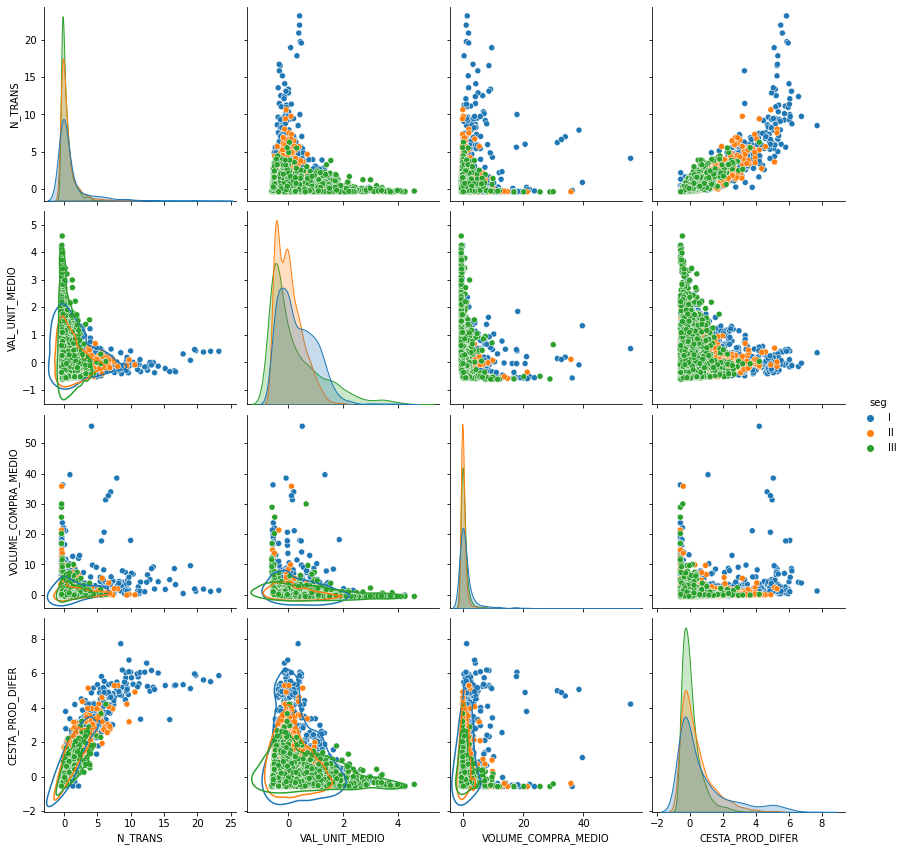

In [40]:
g = sns.pairplot(features2, hue='seg', height=3, diag_kind='kde')
_ = g.map_lower(sns.kdeplot, levels=1, color=".2")

### Encoding da variável categórica

In [15]:
features3 = features2.copy()

# Segmento - Ordinal Encoding
segmento_dict = {'I': 1, 'II': 2, 'III': 3}
features3['seg'] = features3['seg'].map( segmento_dict );

In [16]:
features3 = features3.drop( 'NUM_DOC_DEST', axis=1 )

### FEATURE SELECTION

> The process of reducing the number of input variables when developing a predictive model. 
It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, 
in some cases, to improve the performance of the model.

FILTER (before training) X WRAPPER (ocorre após o treinamento e utiliza as estatísticas geradas pelo próprio modelo)

- Análise estatítica
- Filter: Correlação, ANOVA.
- Wrapper: Árvores de decisão (entropia/**gini**), redes neurais (dropout/**relevância**)
- Correlação x Relevância
- Multicolinearidade -> Análise Discriminante Linear (LDA) ?


### Dividindo os dados em conjuntos de treinamento, teste e validação

#### Setup:
    - Full data 100% 
    - test      20%  -> Generalization!
    - training  80%, sendo 80% train + 20% validation -> Aprendizado!
    
O conjunto de treinamento possui 2.959 linhas e 4 colunas, enquanto o conjunto de teste possui 740 linhas e 3 colunas. 

In [18]:
features4 = features3.copy()
# features4.to_pickle('../data/features4.pickle')

In [80]:
features4 = pd.read_pickle('../data/features4.pickle')

In [81]:
class_col = 'seg'
my_vars = list(features4.columns[features4.columns != class_col])
X = features4[my_vars]
X = np.asarray(X).astype('float32')

y = features4[[class_col]].values.ravel()

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [82]:
# # # split training into train and test datset
X_train, X_test, y_train, y_test = ms.train_test_split(X, dummy_y, test_size=0.2, random_state=42)

print( X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2959, 4) (2959, 3) (740, 4) (740, 3)


In [83]:
# the second split to create the final training set and the validation set:
X_train, X_val, y_train, y_val = ms.train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# DNN Training

In [ ]:
# ==================== 1ª Epoca =======================
# foward: dados * pesos -> função de ativação -> predito
# real - predito = erro
# backpropagation: erro -> derivadas parciais -> update pesos

# ==================== 2ª Epoca =======================
# foward: dados * pesos -> função de ativação -> predito
# real - predito = erro
# backpropagation: erro -> derivadas parciais -> update pesos

# Até os pesos convergirem...

- Definindo o número de neurônios na hidden layer

1. O número de neurônios ocultos deve estar entre o tamanho da camada de entrada e o tamanho da camada de saída.

2. O número de neurônios ocultos deve ser 2/3 do tamanho da camada de entrada, mais o tamanho da camada de saída.

3. O número de neurônios ocultos deve ser menor que o dobro do tamanho da camada de entrada.

Essas três regras forneceram um ponto de partida. Em última análise, a seleção de uma arquitetura para sua rede neural se resume a tentativa e erro. Testamos, nesse sentido, várias combinações para chegarmos no melhor resultado. Além disso, o resultado de pesquisas anteriores em problemas similares serviu para nortear o trabalho. Mais especificamente, os trabalho de [ELDEM, A. (2020)](https://pdfs.semanticscholar.org/b08c/3940271a708e6dad8b915a65c36aa14713aa.pdf), [ELDEM et. al (2018)](https://ieeexplore.ieee.org/document/8620866), [Pinto, J. P., Kelur, S., & Shetty, J. (2018, October)](https://ieeexplore.ieee.org/abstract/document/9057891)

In [84]:
# define baseline model:
model = Sequential()

# Add the first hidden layer
model.add(Dense(50, activation='tanh', input_dim=4))

# Add the second hidden layer
model.add(Dense(20, activation='tanh'))

# Add the output layer 
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 50)                250       
                                                                 
 dense_28 (Dense)            (None, 20)                1020      
                                                                 
 dense_29 (Dense)            (None, 3)                 63        
                                                                 
Total params: 1,333
Trainable params: 1,333
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Train the model for 500 epochs
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=400, verbose=1)

Epoch 1/400
74/74 [==============================] - 1s 7ms/step - loss: 0.7332 - accuracy: 0.6722 - val_loss: 1.0297 - val_accuracy: 0.5392
Epoch 2/400
74/74 [==============================] - 1s 11ms/step - loss: 0.7327 - accuracy: 0.6688 - val_loss: 1.0224 - val_accuracy: 0.5446
Epoch 3/400
74/74 [==============================] - 1s 13ms/step - loss: 0.7316 - accuracy: 0.6700 - val_loss: 1.0250 - val_accuracy: 0.5311
Epoch 4/400
74/74 [==============================] - 1s 8ms/step - loss: 0.7317 - accuracy: 0.6722 - val_loss: 1.0259 - val_accuracy: 0.5378
Epoch 5/400
74/74 [==============================] - 0s 7ms/step - loss: 0.7310 - accuracy: 0.6743 - val_loss: 1.0381 - val_accuracy: 0.5324
Epoch 6/400
74/74 [==============================] - 0s 5ms/step - loss: 0.7327 - accuracy: 0.6730 - val_loss: 1.0298 - val_accuracy: 0.5405
Epoch 7/400
74/74 [==============================] - 0s 5ms/step - loss: 0.7306 - accuracy: 0.6692 - val_loss: 1.0303 - val_accuracy: 0.5392
Epoch 8/400

Epoch 59/400
74/74 [==============================] - 1s 9ms/step - loss: 0.7280 - accuracy: 0.6700 - val_loss: 1.0355 - val_accuracy: 0.5230
Epoch 60/400
74/74 [==============================] - 1s 10ms/step - loss: 0.7287 - accuracy: 0.6730 - val_loss: 1.0352 - val_accuracy: 0.5378
Epoch 61/400
74/74 [==============================] - 1s 10ms/step - loss: 0.7269 - accuracy: 0.6722 - val_loss: 1.0356 - val_accuracy: 0.5351
Epoch 62/400
74/74 [==============================] - 1s 12ms/step - loss: 0.7264 - accuracy: 0.6688 - val_loss: 1.0324 - val_accuracy: 0.5284
Epoch 63/400
74/74 [==============================] - 1s 9ms/step - loss: 0.7273 - accuracy: 0.6764 - val_loss: 1.0446 - val_accuracy: 0.5338
Epoch 64/400
74/74 [==============================] - 1s 9ms/step - loss: 0.7277 - accuracy: 0.6671 - val_loss: 1.0383 - val_accuracy: 0.5405
Epoch 65/400
74/74 [==============================] - 1s 8ms/step - loss: 0.7274 - accuracy: 0.6738 - val_loss: 1.0366 - val_accuracy: 0.5270
Epo

74/74 [==============================] - 0s 7ms/step - loss: 0.7172 - accuracy: 0.6823 - val_loss: 1.0575 - val_accuracy: 0.5230
Epoch 174/400
74/74 [==============================] - 1s 7ms/step - loss: 0.7169 - accuracy: 0.6798 - val_loss: 1.0499 - val_accuracy: 0.5284
Epoch 175/400
74/74 [==============================] - 0s 6ms/step - loss: 0.7162 - accuracy: 0.6810 - val_loss: 1.0548 - val_accuracy: 0.5257
Epoch 176/400
74/74 [==============================] - 0s 6ms/step - loss: 0.7188 - accuracy: 0.6836 - val_loss: 1.0536 - val_accuracy: 0.5257
Epoch 177/400
74/74 [==============================] - 0s 6ms/step - loss: 0.7194 - accuracy: 0.6798 - val_loss: 1.0507 - val_accuracy: 0.5230
Epoch 178/400
74/74 [==============================] - 1s 7ms/step - loss: 0.7179 - accuracy: 0.6789 - val_loss: 1.0477 - val_accuracy: 0.5270
Epoch 179/400
74/74 [==============================] - 0s 6ms/step - loss: 0.7176 - accuracy: 0.6815 - val_loss: 1.0547 - val_accuracy: 0.5311
Epoch 180/400

74/74 [==============================] - 0s 5ms/step - loss: 0.7102 - accuracy: 0.6806 - val_loss: 1.0646 - val_accuracy: 0.5176
Epoch 288/400
74/74 [==============================] - 0s 7ms/step - loss: 0.7113 - accuracy: 0.6777 - val_loss: 1.0647 - val_accuracy: 0.5230
Epoch 289/400
74/74 [==============================] - 0s 6ms/step - loss: 0.7087 - accuracy: 0.6793 - val_loss: 1.0674 - val_accuracy: 0.5243
Epoch 290/400
74/74 [==============================] - 0s 5ms/step - loss: 0.7132 - accuracy: 0.6823 - val_loss: 1.0619 - val_accuracy: 0.5297
Epoch 291/400
74/74 [==============================] - 0s 5ms/step - loss: 0.7112 - accuracy: 0.6836 - val_loss: 1.0622 - val_accuracy: 0.5297
Epoch 292/400
74/74 [==============================] - 0s 5ms/step - loss: 0.7091 - accuracy: 0.6916 - val_loss: 1.0648 - val_accuracy: 0.5297
Epoch 293/400
74/74 [==============================] - 0s 5ms/step - loss: 0.7094 - accuracy: 0.6815 - val_loss: 1.0622 - val_accuracy: 0.5270
Epoch 294/400

### RESULTADOS

Vamos avaliar nosso modelo com base na **acurácia** e **matriz de confusão**.

In [92]:
# Testing accuracy
scores = model.evaluate(X_train, y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))

scores = model.evaluate(X_test, y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1]*100))

74/74 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.6929
Training Accuracy: 69.29%

24/24 [==============================] - 0s 4ms/step - loss: 1.0846 - accuracy: 0.5203
Testing Accuracy: 52.03%



A precisão é de 69.29% e 52.03% no conjunto de treinamento e no conjunto de teste, respectivamente. O que significa que, dadas as seis features de uma nova empresa, nosso modelo é capaz de prever com precisão de ~ 70% se essa empresa pertence ao segmento Autosserviço, Mercado Quente ou Mercado Frio.

In [93]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(val_loss_values) + 1)

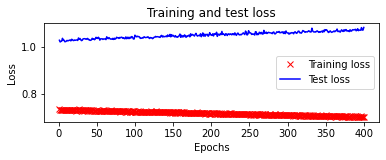

C:\Users\Winicius\AppData\Local\Temp\ipykernel_7732\1204694983.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


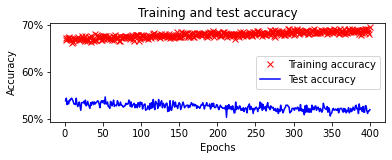

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'rx', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['accuracy'], 'rx', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.show()

24/24 [==============================] - 0s 4ms/step


Text(33.0, 0.5, 'Actual')

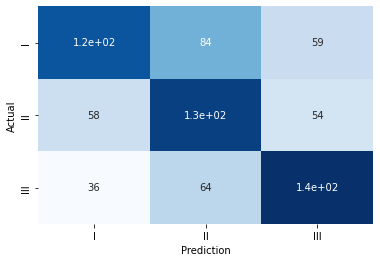

In [95]:
# MATRIZ DE CONFUSÃO

predictions = model.predict(X_test)

c_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

ax = sns.heatmap(c_matrix, annot=True, 
                 xticklabels=['I','II','III'],
                 yticklabels=['I','II','III'], 
                 cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")

In [107]:
# TOP 10
results = pd.read_excel('../Tabela_Resultados.xlsx', sheet_name="4")
results.head(10)

,1st_hidden_layer,2nd_hidden_layer,epoch_number,accuracy_rate
0,Tanh,Tanh,400,0.6929
1,Tanh,Tanh,500,0.6700
2,Relu,Tanh,500,0.6700
3,Relu,Tanh,400,0.6600
4,Tanh,Tanh,300,0.6500
5,Relu,Tanh,200,0.6500
6,Relu,Relu,400,0.6500
7,Relu,Relu,100,0.6500
8,Relu,Relu,200,0.6500
9,Tanh,Sigmoid,400,0.6400


### CONLUSÃO

No presente trabalho, realizamos uma análise exploratória de dados onde observamos a distribuição de cada variável, bem como a relação entre cada variável e a variável de interesse (target). Em seguida, realizamos o pré-processamento de dados para remover dados ausentes e também padronizamos nossos dados utilizando uma abordagem robusta devido a presença de valores atípicos. Por fim, dividimos nossos dados originais aleatoriamente em um conjunto de treinamento, um conjunto de validação e um conjunto de teste.

Em seguida, analisamos a arquitetura do MLP que usamos, que consiste em 2 camadas ocultas, com 50 nós na primeira camada oculta e 20 nós na segunda camada oculta. Em seguida, implementamos esse MLP no Keras usando o modelo sequencial, que nos permite empilhar camadas umas sobre as outras. Então, treinamos nosso MLP usando o conjunto de treinamento, utiizando o algoritmo otimizador Adam para modificar os pesos e vieses na rede neural em mais de 200 iterações, melhorando gradualmente a precisão do modelo.

Por fim, avaliamos nosso modelo usando métricas como acurácia e matriz de confusão. A melhor precisão alcançada foi de apenas 68,9%. O que significa que, dadas as quatro features de um novo estabelecimento, nosso modelo é capaz de prever com precisão de ~70% se essa empresa pertence ao segmento Autosserviço, Mercado Quente ou Mercado Frio.

Em geral, qualquer limitação no desempenho geralmente se deve à falta de features fortes no conjunto de dados, e não à complexidade da rede neural usada. O conjunto de dados consiste apenas em quatro features, e pode-se argumentar que esses recursos sozinhos são insuficientes para realmente dizer se uma empresa pertence ao segmento de autosserviço, mercado quente ou mercado frio.

---

### REFERÊNCIAS

Eldem, A. (2020). An application of deep neural network for classification of wheat seeds. Avrupa Bilim ve Teknoloji Dergisi, (19), 213-220.

Loy, J. (2019). Neural Network Projects with Python: The ultimate guide to using Python to explore the true power of neural networks through six projects. Packt Publishing Ltd.

Eldem, A., Eldem, H., & Üstün, D. (2018, September). A model of deep neural network for iris classification with different activation functions. In 2018 International Conference on Artificial Intelligence and Data Processing (IDAP) (pp. 1-4). IEEE.

Pinto, J. P., Kelur, S., & Shetty, J. (2018, October). Iris flower species identification using machine learning approach. In 2018 4th International Conference for Convergence in Technology (I2CT) (pp. 1-4). IEEE.